# Sprint 深層学習スクラッチ 畳み込みニューラルネットワーク

* 1次元の畳み込み層を作成する。
* MNISTデータセットを使用する。
    * 入力には全結合のNNと同様、平滑化されたものを用いる。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

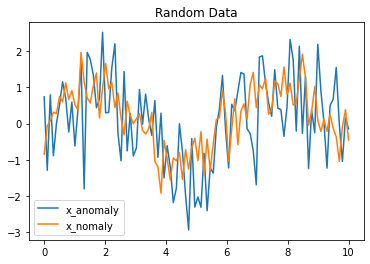

In [2]:
# Sample Data

data_length = 100
n_sample = 100000
anomaly_noise = np.random.randn(data_length)    #異常値は分散が大きい
nomaly_noise  = np.random.randn(data_length)/2  #正常値は分散が小さい

#時系列とラベルを生成
t = np.linspace(0,10,data_length)
x_anomaly = np.array([np.sin(t) + anomaly_noise for i in range(n_sample//2)])
x_nomaly  = np.array([np.sin(t) + nomaly_noise  for i in range(n_sample//2)])
X = np.concatenate([x_anomaly,x_nomaly])
y = np.concatenate([np.ones(n_sample//2),np.zeros(n_sample//2)])

#シャッフル
rand_idx = np.arange(n_sample)
np.random.shuffle(rand_idx)
X = X[rand_idx,:]
y = y[rand_idx]

#描画
# fig, ax = plt.subplots()
plt.plot(t,x_anomaly[0,:], label='x_anomaly')
plt.plot(t,x_nomaly[0,:], label='x_nomaly')
plt.title('Random Data')
plt.legend()
plt.show()

In [3]:
# Onehotencoding

enc = OneHotEncoder(handle_unknown='ignore')
y_reshaped = y.reshape(-1, 1)
# print(y.shape)
y_transformed = enc.fit_transform(y_reshaped)
# print(y_transformed)

In [4]:
class Cov1d:
    pass

In [5]:
def flatten(arraY_2d):
    array_1d = array_2d.flatten()
    return array_1d

## 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成

* チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成せよ。
* 重みの初期化に関するクラスは必要に応じて作り変える。
    * Xavierの初期値も同様
* Strideは1に固定
* Batchも1に固定

In [13]:
class CNN_1d_:
    """
    畳みこむ！

    Parameters
    ----------
    input_data: 次の形のndarray (データ数, チャンネル数, 高さ, 横幅)
        4次元配列からなる入力データ。
    filter_h: 
        フィルターの高さ
    filter_w:
        フィルターの横幅
    stride: 
        ストライド
    pad: 
        パディング

    Returns
    ----------
    A : 次の形のndarray, shape (, )

    """
    def __init__ (self, input_data, filter_h, filter_w, stride=1, pad=0):
        """
        初期化メソッド
        バイアス、ストライド、とパディングを引数として受け取る。
        W : フィルター（重み）は（FN, C, FH, FW）の4次元の形状
            FN: Filter_number
            C: Channel（入力データのチャンネルと同数）
            FH: filter_height
            FW: filter_weight
            
        """
        self.X = input_data
        self.filter_h = filter_h
        self.filter_w = filter_w
        self.stride = stride
        self.pad = pad
        self.W = W
        self.b = b
        # self.b = parameters["bias"]
        
    def initialize_filter_and_bias(self, filter_h, filter_w):
        parameters = {"filter": np.random.randn(filter_h, filter_w) * 0.1,
                      "bias": np.zeros((1, 1))}
        return parameters
    
    def forward(self, X):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = X.shape # (入力データ数, チャンネル, 入力データの高さ, 入力データの横幅)
        output_h = int(1 + (H + 2 * self.pad - FH) / self.stride)
        output_w = int(1 + (W + 2 * self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        # im2colはバッチ数含めた4次元の入力データを2次元に変換する。
        # col = (, フィルターの要素数の総和（チャンネル数×サイズ)）
        col_W = self.W.reshape(FN, -1).T # フィルターの展開
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        # z = np.dot(parameters["filter"], self.X) + parameters["bias"]
        
        return out

In [9]:
# テスト用のランダムデータ
# 高さ28、横幅28、1チャンネル（奥行）のデータが10個
# X[0]： Xの1個目のデータとなる。
# X[0, 0] || X[0][0]： Xの1個目のデータの1チャンネル目の空間データ

X = np.random.rand(10, 1, 28, 28)
X.shape

(10, 1, 28, 28)

In [15]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    ＜畳み込み演算の実装＞
    
    3次元の入力データ（バッチ数を含めて4次元）を2次元の行列に変換する。
    フィルター（重み）を適用する領域を横方向に1列に展開します。
    
    例）X = np.random.rand(1, 3, 7, 7)　入力データ：バッチサイズ1、チャンネル数3、7×7
    例）im2col(X, 5, 5, stride=1, pad=0)　フィルター設定：5×5、ストライド1, パッド0
    例）出力：(9, 75)
    
    75はフィルター（重み）の要素数の総和（チャンネル数3、サイズ5×5）
    
    im2col用いて、入力データを展開後は、フィルター（重み）を縦方向1列に展開して、2つの内積を計算するだけ。
    （全結合層のAffineレイヤで行ったことと同じ。）
    最後に、出力データのサイズにreshapeする。
    
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
    
    Returns
    -------
    col : 2次元配列（フィルターの適用回数, 要素数）
    """
    N, C, H, W = input_data.shape # バッチサイズ、チャンネル数、行数、列数
    out_h = (H + 2*pad - filter_h)//stride + 1 
    # 出力の高さ = (7 + 2*0 - 5) // 1 + 1 切り捨て除算して出力行数を算出
    out_w = (W + 2*pad - filter_w)//stride + 1 
    # 出力の幅 = (7 + 2*0 - 5) // 1 + 1 out_hと同じく出力列数: 
    
    # パディング後の入力データをimgへ代入
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant') 
    # np.pad：第1引数はN次元の配列、第2引数は前後の特定文字の個数
    # 今回の場合、4次元の配列に、
    # バッチサイズ：(0,0) = パッド無し、チャンネル数：(0,0) = パッド無し、行数：(pad分, pad分)、列数：(pad分、pad分)

    # 返り値用の空の配列の作成
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w)) 
    # colの中身：バッチサイズ、チャンネル数、フィルター行数、フィルター列数、出力行数、出力列数

    
    for y in range(filter_h):
        y_max = y + stride*out_h # 出力の高さ最大値（パディング済み）= 各高さ + ストライド数 + 出力の高さ
        for x in range(filter_w):
            x_max = x + stride*out_w # 出力の幅の最大値（パディング済み）= 各幅 + ストライド数 * 出力の幅（パディング済み）
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride] 
            # パディングする行列への条件をストライド条件と一緒に(pad, pad)へ代入して、imgリストのnp.padを完成させる。

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1) 
    # colの中身をtransposeを用いて軸の順番を変え、倒置して、reshapeする。
    
    # 返り値 col の詳細
    # 出力行数：フィルターの適用回数と行数は同義（バッチサイズ×フィルター高さ×フィルター幅）
    # 出力列数：フィルター適用時に抽出した要素（-1で行数に準じた形状に成形）
    
    return col

In [ ]:
data = [[1,2,3],[4,5,6]]
np.pad(data, [(0,1),(2,3)], 'constant')

In [8]:
(x, x_max, y, y_max, stride) = (0, 2, 0, 2, 1)
img = [[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]]
img[0][0:5:1]

# img[y:y_max:stride, x:x_max:stride]

[1, 2, 3, 4, 5]

1. im2colの解析
2. im2colとフィルターの内積を構築
    * フィルターを一列展開に変換
3. 最後に出力データをreshapeする。

In [ ]:
# 2.im2colとフィルターの内積を構築
